<a href="https://colab.research.google.com/github/daveikin/pr/blob/main/Practica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 
# Import Packages
#
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import cv2
import random
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, BatchNormalization

print('Packages imported.')


Packages imported.


In [ ]:
def read_images(path, use_convert):  
    X = []
    y = []
    n=[2095, 1963, 1846, 1664, 1508, 1182, 1028, 884, 740, 596, 397, 199, 1]#название изображения для 360,330,...,0 градусов
    for p in os.listdir(path):        
        img_array = cv2.imread(os.path.join(path, p), cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, dsize=(80, 80))
        X.append(new_img_array)
       # print(p)
        if (use_convert):
            i=0
            a=11
            while i<13:# преобразование названия изображения в угол
                if (int(p[:4]))<(n[i+1]):
                    i+=1
                    a-=1
                else:                    
                    angle=(30*a+(30/(n[i]-n[i+1]+1))*((int(p[:4]))-n[i+1]))
                    y.append(angle)
                    break
    return (X, y)
  
def read_train_images(path):
    return read_images(path, True)

def read_test_images(path):
    return read_images(path, False)

def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(10,10)):
    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns+1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        plt.imshow(list_of_images[i], cmap="gray")
        plt.axis('off')
        if len(list_of_titles) >= len(list_of_images):
            plt.title(list_of_titles[i])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
print('Reading train image files...')
main_dir = "/content/drive/My Drive/youbotfinal/"
train_dir = "training"
path = os.path.join(main_dir,train_dir)
(X_train, y_train) = read_train_images(path)
print('Reading train image files done.')

Reading train image files...
Reading train image files done.


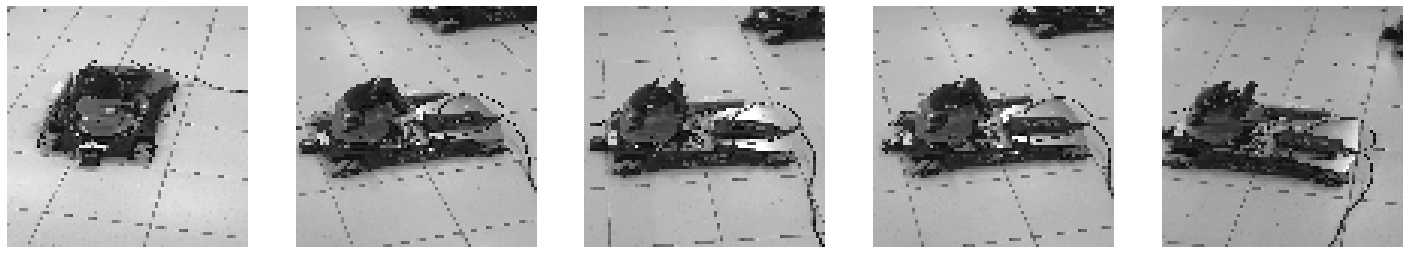

In [ ]:
# Show some sample images
#            
random_images = []
for i in range(5):
    r = random.randint(1,len(X_train)-1)    
    random_images.append(X_train[r])    
grid_display(random_images, [], 5, (25, 25))


In [ ]:
#
# Make numpy arrays and normalize image data
#
X_train = np.array(X_train).reshape(-1, 80, 80, 1)
y_train = np.array(y_train)

X_train_normalized =  X_train / 255.0
y_train_normalized =  y_train/360

print(f'X_train {X_train_normalized.shape}')
print(f'y_train {y_train_normalized.shape}')

X_train (1886, 80, 80, 1)
y_train (1886,)


In [ ]:
!git clone https://github.com/keras-team/keras-tuner.git

In [ ]:
%cd keras-tuner
!pip install .

In [ ]:
!pip uninstall -y tensorflow
!pip install tensorflow-gpu==2.0.0rc1

In [ ]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import utils
from google.colab import files
from kerastuner import RandomSearch, Hyperband, BayesianOptimization
import numpy as np

In [ ]:
def build_model(hp):
    model = Sequential()
    input_shape = X_train_normalized.shape[1:]

    # Adds a densely-connected layer with 64 units 
    model.add(Conv2D(64,(3,3), activation = 'relu', input_shape = input_shape))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))

    model.add(Conv2D(64,(3,3), activation = 'relu', input_shape = input_shape))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    # Add flatten layer
    model.add(Flatten())
   # activation_choice = hp.Choice('activation', values=['relu', 'sigmoid', 'tanh', 'elu', 'selu'])    
    model.add(Dense(units=hp.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=256,    # минимальное количество нейронов - 128
                                   max_value=1024,   # максимальное количество - 1024
                                   step=32),
                    input_dim=784,
                    activation='relu'))
    model.add(Dense(units=hp.Int('units_hidden',        
                                   min_value=128,   
                                   max_value=600,   
                                   step=32),
                    activation='relu'))   
    model.add(Dense(1))
    model.compile(optimizer="adam",
              loss='mse',
              metrics=['mae'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,                 # функция создания модели
    objective='mean_absolute_error',    # метрика, которую нужно оптимизировать - 
                                 # доля правильных ответов на проверочном наборе данных
    max_trials=5,               # максимальное количество запусков обучения 
    directory='test_directory'   # каталог, куда сохраняются обученные сети  
    )

In [ ]:
tuner.search_space_summary()

In [ ]:
tuner.search(X_train,                  # Данные для обучения
             y_train,                  # Правильные ответы
             batch_size=32,           # Размер мини-выборки
             epochs=25,                # Количество эпох обучения 
             validation_split=0.2,     # Часть данных, которая будет использоваться для проверки
             )

In [ ]:
tuner.results_summary()

NameError: ignored

In [ ]:
#
# Build Convolutional Neural Net 
#

model = Sequential()

input_shape = X_train_normalized.shape[1:]


model.add(Conv2D(64,(3,3), activation = 'relu', input_shape = input_shape))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64,(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64,(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Flatten())
model.add(Dense(960, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(360, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1))

model.compile(optimizer="adam",
              loss='mse',
              metrics=['mae'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
#
# Train Network 
#
model.fit(X_train_normalized, y_train_normalized, epochs=25, batch_size=1, validation_split=0.2)

#model.fit(X_train_normalized, y_train,
          #    batch_size=batch_size,
            #  epochs=epochs,
            #  validation_data=(x_test, y_test),
            #  shuffle=True)

Train on 1508 samples, validate on 378 samples
Epoch 1/25
1508/1508 [==============================] - 11s 8ms/sample - loss: 0.0300 - mean_absolute_error: 0.1085 - val_loss: 0.0134 - val_mean_absolute_error: 0.0983
Epoch 2/25
1508/1508 [==============================] - 7s 5ms/sample - loss: 0.0039 - mean_absolute_error: 0.0447 - val_loss: 0.0112 - val_mean_absolute_error: 0.0871
Epoch 3/25
1508/1508 [==============================] - 7s 4ms/sample - loss: 0.0029 - mean_absolute_error: 0.0386 - val_loss: 0.0458 - val_mean_absolute_error: 0.1987
Epoch 4/25
1508/1508 [==============================] - 7s 4ms/sample - loss: 0.0030 - mean_absolute_error: 0.0397 - val_loss: 0.0513 - val_mean_absolute_error: 0.2129
Epoch 5/25
1508/1508 [==============================] - 6s 4ms/sample - loss: 0.0040 - mean_absolute_error: 0.0428 - val_loss: 0.0263 - val_mean_absolute_error: 0.1428
Epoch 6/25
1508/1508 [==============================] - 7s 4ms/sample - loss: 0.0024 - mean_absolute_error: 0.03

In [ ]:
# 
# Predict
#
main_dir = "/content/drive/My Drive/youbotfinal"
test_dir = "test"
test_path = os.path.join(main_dir,test_dir)
print('reading Test images...')
(X_test, y_test) = read_train_images(test_path)

X_test = np.array(X_test).reshape(-1, 80, 80, 1)
y_test = np.array(y_test)
X_test_normalized =  X_test / 255.0
print('Reading test images done')

reading Test images...
Reading test images done


In [ ]:
print(y_test)

[  1.35678392   2.86432161   4.3718593    5.87939698   7.38693467
   8.89447236  10.40201005  11.90954774  14.92462312  13.41708543
  16.4321608   17.93969849  20.95477387  19.44723618  22.46231156
  23.96984925  25.47738693  26.98492462  28.49246231  30.15075377
  31.65829146  33.16582915  34.67336683  36.18090452  37.68844221
  39.1959799   40.70351759  42.21105528  43.71859296  46.73366834
  45.22613065  48.24120603  49.74874372  51.25628141  52.7638191
  54.27135678  57.28643216  55.77889447  58.79396985  60.45
  61.95        63.45        64.95        66.45        69.45
  67.95        70.95        72.45        75.45        73.95
  76.95        78.45        81.45        79.95        82.95
  84.45        85.95        87.45        88.95        90.82758621
  94.96551724  92.89655172  97.03448276  99.10344828 101.17241379
 103.24137931 105.31034483 107.37931034 109.44827586 111.51724138
 113.5862069  115.65517241 117.72413793 122.06896552 120.
 124.13793103 126.20689655 128.27586207 130

Реальный угол : 95.0 ,
Угол, предсказанный нейросетью: 166.0


(-0.5, 79.5, 79.5, -0.5)

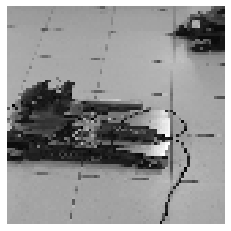

In [ ]:
random_images = []
random_titles = []

i=60
print("Реальный угол :", round(y_test[i]),",\nУгол, предсказанный нейросетью:", round(y_test[i]+70.7))        
#cv2.imshow(X_test[i])

plt.imshow(X_test[i].reshape(80, 80), cmap="gray")
plt.axis('off')

In [ ]:
random_images = []
random_titles = []
'''
for i in range(30):
    r = random.randint(1, len(X_test)-1)    
    random_images.append(X_test[r].reshape(80, 80))    
    
    random_titles.append(pred)
   '''
   
        
grid_display(X_test, random_titles, 5, (25, 25))

In [ ]:
pred = model.predict(X_train)

In [ ]:
print("Предсказанный угол :", pred[360][0], ", правильный угол:", y_train[360])

In [ ]:
mse, mae = model.evaluate(X_test, y_test, verbose=0)
print("Средняя абсолютная ошибка :", mae)